In [34]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------
import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data]   Package reuters is already up-to-date!


## Word Vectors

Word Vectors are often used as a fundamental component for downstream NLP tasks, e.g. question answering, text generation, translation, etc., so it is important to build some intuitions as to their strengths and weaknesses. Here, you will explore two types of word vectors: those derived from *co-occurrence matrices*, and those derived via *GloVe*.

**Note on Terminology:** The terms "word vectors" and "word embeddings" are often used interchangeably. The term "embedding" refers to the fact that we are encoding aspects of a word's meaning in a lower dimensional space. As [Wikipedia](https://en.wikipedia.org/wiki/Word_embedding) states, "*conceptually it involves a mathematical embedding from a space with one dimension per word to a continuous vector space with a much lower dimension*".

## Part 1: Count-Based Word Vectors
Most word vector models start from the following idea:

*You shall know a word by the company it keeps ([Firth, J. R. 1957:11](https://en.wikipedia.org/wiki/John_Rupert_Firth))*

Many word vector implementations are driven by the idea that similar words, i.e., (near) synonyms, will be used in similar contexts. As a result, similar words will often be spoken or written along with a shared subset of words, i.e., contexts. By examining these contexts, we can try to develop embeddings for our words. With this intuition in mind, many "old school" approaches to constructing word vectors relied on word counts. Here we elaborate upon one of those strategies, *co-occurrence matrices* (for more information, see [here](http://web.stanford.edu/class/cs124/lec/vectorsemantics.video.pdf) or [here](https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285)).

### Co-Occurrence

A co-occurrence matrix counts how often things co-occur in some environment. Given some word $w_i$ occurring in the document, we consider the *context window* surrounding $w_i$. Supposing our fixed window size is $n$, then this is the $n$ preceding and $n$ subsequent words in that document, i.e. words $w_{i-n} \dots w_{i-1}$ and $w_{i+1} \dots w_{i+n}$. We build a *co-occurrence matrix* $M$, which is a symmetric word-by-word matrix in which $M_{ij}$ is the number of times $w_j$ appears inside $w_i$'s window among all documents.

**Example: Co-Occurrence with Fixed Window of n=1**:

Document 1: "all that glitters is not gold"

Document 2: "all is well that ends well"


|     *    | `<START>` | all | that | glitters | is   | not  | gold  | well | ends | `<END>` |
|----------|-------|-----|------|----------|------|------|-------|------|------|-----|
| `<START>`    | 0     | 2   | 0    | 0        | 0    | 0    | 0     | 0    | 0    | 0   |
| all      | 2     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| that     | 0     | 1   | 0    | 1        | 0    | 0    | 0     | 1    | 1    | 0   |
| glitters | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 0    | 0   |
| is       | 0     | 1   | 0    | 1        | 0    | 1    | 0     | 1    | 0    | 0   |
| not      | 0     | 0   | 0    | 0        | 1    | 0    | 1     | 0    | 0    | 0   |
| gold     | 0     | 0   | 0    | 0        | 0    | 1    | 0     | 0    | 0    | 1   |
| well     | 0     | 0   | 1    | 0        | 1    | 0    | 0     | 0    | 1    | 1   |
| ends     | 0     | 0   | 1    | 0        | 0    | 0    | 0     | 1    | 0    | 0   |
| `<END>`      | 0     | 0   | 0    | 0        | 0    | 0    | 1     | 1    | 0    | 0   |

**Note:** In NLP, we often add `<START>` and `<END>` tokens to represent the beginning and end of sentences, paragraphs or documents. In thise case we imagine `<START>` and `<END>` tokens encapsulating each document, e.g., "`<START>` All that glitters is not gold `<END>`", and include these tokens in our co-occurrence counts.

The rows (or columns) of this matrix provide one type of word vectors (those based on word-word co-occurrence), but the vectors will be large in general (linear in the number of distinct words in a corpus). Thus, our next step is to run *dimensionality reduction*. In particular, we will run *SVD (Singular Value Decomposition)*, which is a kind of generalized *PCA (Principal Components Analysis)* to select the top $k$ principal components. Here's a visualization of dimensionality reduction with SVD. In this picture our co-occurrence matrix is $A$ with $n$ rows corresponding to $n$ words. We obtain a full matrix decomposition, with the singular values ordered in the diagonal $S$ matrix, and our new, shorter length-$k$ word vectors in $U_k$.

This reduced-dimensionality co-occurrence representation preserves semantic relationships between words, e.g. *doctor* and *hospital* will be closer than *doctor* and *dog*.

**Notes:** If you can barely remember what an eigenvalue is, here's [a slow, friendly introduction to SVD](https://davetang.org/file/Singular_Value_Decomposition_Tutorial.pdf).

### Plotting Co-Occurrence Word Embeddings

Here, we will be using the Reuters (business and financial news) corpus. If you haven't run the import cell at the top of this page, please run it now (click it and press SHIFT-RETURN). The corpus consists of 10,788 news documents totaling 1.3 million words. These documents span 90 categories and are split into train and test. For more details, please see https://www.nltk.org/book/ch02.html. We provide a `read_corpus` function below that pulls out only articles from the "crude" (i.e. news articles about oil, gas, etc.) category. The function also adds `<START>` and `<END>` tokens to each of the documents, and lowercases words. You do **not** have to perform any other kind of pre-processing.

In [35]:
def read_corpus(category="crude"):
    """ Read files from the specified Reuter's category.
        Params:
            category (string): category name
        Return:
            list of lists, with words from each of the processed files
    """
    files = reuters.fileids(category)
    return [[START_TOKEN] + [w.lower() for w in list(reuters.words(f))] + [END_TOKEN] for f in files]


Let's have a look what these documents are like….

In [36]:
reuters_corpus = read_corpus()
pprint.pprint(reuters_corpus[:5], compact=True, width=100)

[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

### Question 1.1: Implement `distinct_words` (2 points)

Write a method to work out the distinct words (word types) that occur in the corpus. You can do this with `for` loops, but it's more efficient to do it with Python list comprehensions. In particular, [this](https://coderwall.com/p/rcmaea/flatten-a-list-of-lists-in-one-line-in-python) may be useful to flatten a list of lists. If you're not familiar with Python list comprehensions in general, here's [more information](https://python-3-patterns-idioms-test.readthedocs.io/en/latest/Comprehensions.html).

You may find it useful to use [Python sets](https://www.w3schools.com/python/python_sets.asp) to remove duplicate words.

In [37]:
def distinct_words(corpus):
    """ Determine a list of distinct words for the corpus.
        Params:
            corpus (list of list of strings): corpus of documents
        Return:
            corpus_words (list of strings): list of distinct words across the corpus, sorted (using python 'sorted' function)
            num_corpus_words (integer): number of distinct words across the corpus
    """
    corpus_words = []
    num_corpus_words = -1
    # ------------------
    # Write your implementation here.
    # ------------------
    corpus_words_set = set(word for document in corpus for word in document)

    corpus_words = sorted(corpus_words_set)

    num_corpus_words = len(corpus_words_set)

    return corpus_words, num_corpus_words

In [38]:
# ---------------------
# Run this sanity check
# Note that this not an exhaustive check for correctness.
# ---------------------

# Define toy corpus
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
test_corpus_words, num_corpus_words = distinct_words(test_corpus)

# Correct answers
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
ans_num_corpus_words = len(ans_test_corpus_words)

# Test correct number of words
assert(num_corpus_words == ans_num_corpus_words), "Incorrect number of distinct words. Correct: {}. Yours: {}".format(ans_num_corpus_words, num_corpus_words)

# Test correct words
assert (test_corpus_words == ans_test_corpus_words), "Incorrect corpus_words.\nCorrect: {}\nYours:   {}".format(str(ans_test_corpus_words), str(test_corpus_words))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.2: Implement `compute_co_occurrence_matrix` (3 points)

Write a method that constructs a co-occurrence matrix for a certain window-size $n$ (with a default of 4), considering words $n$ before and $n$ after the word in the center of the window. Here, we start to use `numpy (np)` to represent vectors, matrices, and tensors.


In [39]:
def compute_co_occurrence_matrix(corpus, window_size=4):
    """ Compute co-occurrence matrix for the given corpus and window_size (default of 4).

        Note: Each word in a document should be at the center of a window. Words near edges will have a smaller
              number of co-occurring words.

              For example, if we take the document "<START> All that glitters is not gold <END>" with window size of 4,
              "All" will co-occur with "<START>", "that", "glitters", "is", and "not".

        Params:
            corpus (list of list of strings): corpus of documents
            window_size (int): size of context window
        Return:
            M (a symmetric numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)):
                Co-occurence matrix of word counts.
                The ordering of the words in the rows/columns should be the same as the ordering of the words given by the distinct_words function.
            word2Ind (dict): dictionary that maps word to index (i.e. row/column number) for matrix M.
    """
    words, num_words = distinct_words(corpus)
    M = np.zeros((num_words,num_words))
    word2Ind = {words[i]: i for i in range(0, len(words), 1)}
    # ------------------
    # Write your implementation here.
    # ------------------
    for document in corpus:
        for idx, word in enumerate(document):
            window_start_pos = max(
                                    0,
                                    idx - window_size
                                  )
            window_end_pos = min(
                                  len(document),
                                  idx + window_size + 1
                                )

            word_ind = word2Ind[word]

            for window_word in document[window_start_pos:window_end_pos]:
                if window_word != word:
                    window_word_ind = word2Ind[window_word]
                    M[word_ind, window_word_ind] += 1

    return M, word2Ind

In [40]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# ---------------------

# Define toy corpus and get student's co-occurrence matrix
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)

# Correct M and word2Ind
M_test_ans = np.array(
    [[0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,],
     [0., 0., 1., 1., 0., 0., 0., 0., 0., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 1., 0.,],
     [0., 1., 0., 0., 0., 0., 0., 0., 0., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 0., 1., 1.,],
     [0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,],
     [1., 0., 0., 0., 0., 0., 0., 1., 0., 0.,],
     [0., 0., 0., 0., 0., 1., 1., 0., 0., 0.,],
     [0., 0., 1., 0., 1., 1., 0., 0., 0., 1.,],
     [1., 0., 0., 1., 1., 0., 0., 0., 1., 0.,]]
)
ans_test_corpus_words = sorted([START_TOKEN, "All", "ends", "that", "gold", "All's", "glitters", "isn't", "well", END_TOKEN])
word2Ind_ans = dict(zip(ans_test_corpus_words, range(len(ans_test_corpus_words))))

# Test correct word2Ind
assert (word2Ind_ans == word2Ind_test), "Your word2Ind is incorrect:\nCorrect: {}\nYours: {}".format(word2Ind_ans, word2Ind_test)

# Test correct M shape
assert (M_test.shape == M_test_ans.shape), "M matrix has incorrect shape.\nCorrect: {}\nYours: {}".format(M_test.shape, M_test_ans.shape)

# Test correct M values
for w1 in word2Ind_ans.keys():
    idx1 = word2Ind_ans[w1]
    for w2 in word2Ind_ans.keys():
        idx2 = word2Ind_ans[w2]
        student = M_test[idx1, idx2]
        correct = M_test_ans[idx1, idx2]
        if student != correct:
            print("Correct M:")
            print(M_test_ans)
            print("Your M: ")
            print(M_test)
            raise AssertionError("Incorrect count at index ({}, {})=({}, {}) in matrix M. Yours has {} but should have {}.".format(idx1, idx2, w1, w2, student, correct))

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.3: Implement `reduce_to_k_dim` (1 point)

Construct a method that performs dimensionality reduction on the matrix to produce k-dimensional embeddings. Use SVD to take the top k components and produce a new matrix of k-dimensional embeddings.

**Note:** All of numpy, scipy, and scikit-learn (`sklearn`) provide *some* implementation of SVD, but only scipy and sklearn provide an implementation of Truncated SVD, and only sklearn provides an efficient randomized algorithm for calculating large-scale Truncated SVD. So please use [sklearn.decomposition.TruncatedSVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).

In [41]:
def reduce_to_k_dim(M, k=2):
    """ Reduce a co-occurence count matrix of dimensionality (num_corpus_words, num_corpus_words)
        to a matrix of dimensionality (num_corpus_words, k) using the following SVD function from Scikit-Learn:
            - http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html

        Params:
            M (numpy matrix of shape (number of unique words in the corpus , number of unique words in the corpus)): co-occurence matrix of word counts
            k (int): embedding size of each word after dimension reduction
        Return:
            M_reduced (numpy matrix of shape (number of corpus words, k)): matrix of k-dimensioal word embeddings.
                    In terms of the SVD from math class, this actually returns U * S
    """
    n_iters = 10     # Use this parameter in your call to `TruncatedSVD`
    print("Running Truncated SVD over %i words..." % (M.shape[0]))
        # ------------------
        # Write your implementation here.
        # ------------------
    svd = TruncatedSVD(n_components=k, n_iter=n_iters)
    M_reduced = svd.fit_transform(M)

    print("Done.")
    return M_reduced

In [42]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness
# In fact we only check that your M_reduced has the right dimensions.
# ---------------------

# Define toy corpus and run student code
test_corpus = ["{} All that glitters isn't gold {}".format(START_TOKEN, END_TOKEN).split(" "), "{} All's well that ends well {}".format(START_TOKEN, END_TOKEN).split(" ")]
M_test, word2Ind_test = compute_co_occurrence_matrix(test_corpus, window_size=1)
M_test_reduced = reduce_to_k_dim(M_test, k=2)

# Test proper dimensions
assert (M_test_reduced.shape[0] == 10), "M_reduced has {} rows; should have {}".format(M_test_reduced.shape[0], 10)
assert (M_test_reduced.shape[1] == 2), "M_reduced has {} columns; should have {}".format(M_test_reduced.shape[1], 2)

# Print Success
print ("-" * 80)
print("Passed All Tests!")
print ("-" * 80)

Running Truncated SVD over 10 words...
Done.
--------------------------------------------------------------------------------
Passed All Tests!
--------------------------------------------------------------------------------


### Question 1.4: Implement `plot_embeddings` (1 point)

Here you will write a function to plot a set of 2D vectors in 2D space. For graphs, we will use Matplotlib (`plt`).

For this example, you may find it useful to adapt [this code](https://www.pythonmembers.club/2018/05/08/matplotlib-scatter-plot-annotate-set-text-at-label-each-point/). In the future, a good way to make a plot is to look at [the Matplotlib gallery](https://matplotlib.org/gallery/index.html), find a plot that looks somewhat like what you want, and adapt the code they give.

In [43]:
def plot_embeddings(M_reduced, word2Ind, words):
    """ Plot in a scatterplot the embeddings of the words specified in the list "words".
        NOTE: do not plot all the words listed in M_reduced / word2Ind.
        Include a label next to each point.

        Params:
            M_reduced (numpy matrix of shape (number of unique words in the corpus , 2)): matrix of 2-dimensioal word embeddings
            word2Ind (dict): dictionary that maps word to indices for matrix M
            words (list of strings): words whose embeddings we want to visualize
    """

    # ------------------
    # Write your implementation here.
    # ------------------
    for word in words:
        if word in word2Ind:
            word_ind = word2Ind[word]
            embedding = M_reduced[word_ind]

            plt.scatter(embedding[0], embedding[1], color='blue')

            plt.annotate(word, (embedding[0], embedding[1]), fontsize=10, ha='left')

    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.title('Word Embeddings Visualisation')
    plt.grid()
    plt.show()

--------------------------------------------------------------------------------
Outputted Plot:


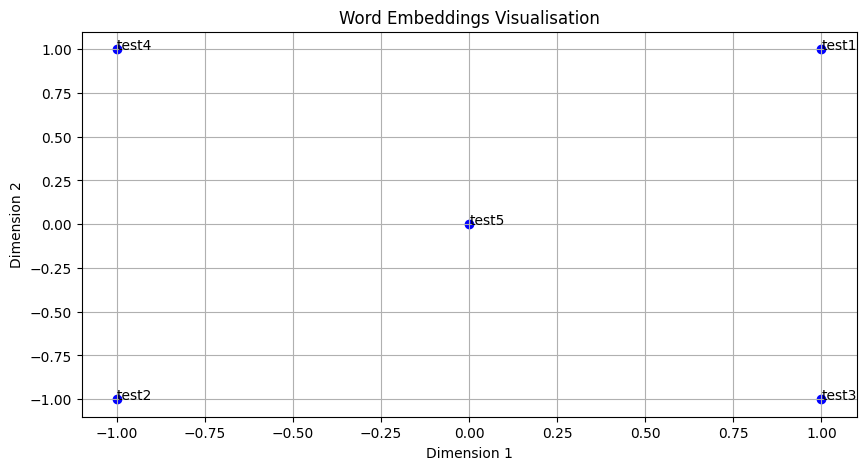

--------------------------------------------------------------------------------


In [44]:
# ---------------------
# Run this sanity check
# Note that this is not an exhaustive check for correctness.
# The plot produced should look like the "test solution plot" depicted below.
# ---------------------

print ("-" * 80)
print ("Outputted Plot:")

M_reduced_plot_test = np.array([[1, 1], [-1, -1], [1, -1], [-1, 1], [0, 0]])
word2Ind_plot_test = {'test1': 0, 'test2': 1, 'test3': 2, 'test4': 3, 'test5': 4}
words = ['test1', 'test2', 'test3', 'test4', 'test5']
plot_embeddings(M_reduced_plot_test, word2Ind_plot_test, words)

print ("-" * 80)

### Question 1.5: Co-Occurrence Plot Analysis (3 points)

Now we will put together all the parts you have written! We will compute the co-occurrence matrix with fixed window of 4 (the default window size), over the Reuters "crude" (oil) corpus. Then we will use TruncatedSVD to compute 2-dimensional embeddings of each word. TruncatedSVD returns U\*S, so we need to normalize the returned vectors, so that all the vectors will appear around the unit circle (therefore closeness is directional closeness). **Note**: The line of code below that does the normalizing uses the NumPy concept of *broadcasting*. If you don't know about broadcasting, check out
[Computation on Arrays: Broadcasting by Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/02.05-computation-on-arrays-broadcasting.html).

Run the below cell to produce the plot. It'll probably take a few seconds to run. What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have?  **Note:** "bpd" stands for "barrels per day" and is a commonly used abbreviation in crude oil topic articles.

Running Truncated SVD over 8185 words...
Done.


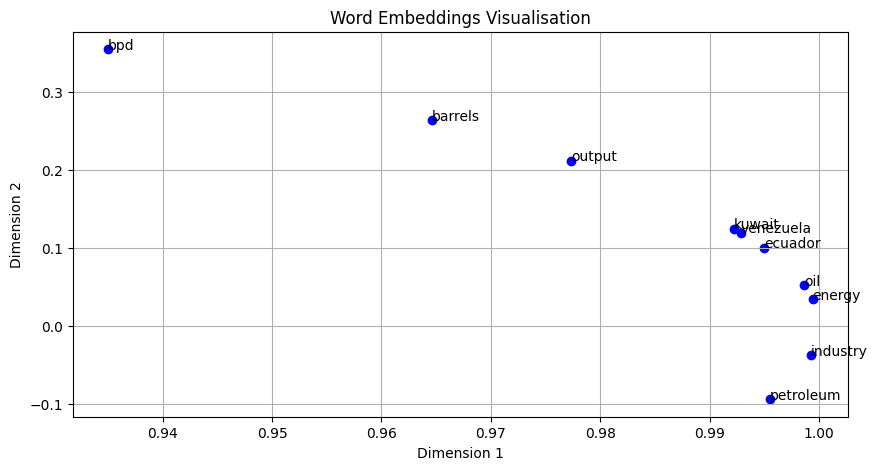

In [45]:
# -----------------------------
# Run This Cell to Produce Your Plot
# ------------------------------
reuters_corpus = read_corpus()
M_co_occurrence, word2Ind_co_occurrence = compute_co_occurrence_matrix(reuters_corpus)
M_reduced_co_occurrence = reduce_to_k_dim(M_co_occurrence, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced_co_occurrence, axis=1)
M_normalized = M_reduced_co_occurrence / M_lengths[:, np.newaxis] # broadcasting

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']

plot_embeddings(M_normalized, word2Ind_co_occurrence, words)

## Part 2: Prediction-Based Word Vectors

As discussed in class, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we shall explore the embeddings produced by GloVe. Please revisit the class notes and lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Then run the following cells to load the GloVe vectors into memory. **Note**: If this is your first time to run these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.

In [46]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each length 200
    """
    import gensim.downloader as api
    wv_from_bin = api.load("glove-wiki-gigaword-200")  # Load pre-trained GloVe embeddings
    print("Loaded vocab size %i" % len(wv_from_bin.index_to_key))  # Use index_to_key to get vocab size
    return wv_from_bin

wv_from_bin = load_embedding_model()

Loaded vocab size 400000


### Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

In [47]:
def get_matrix_of_vectors(wv_from_bin, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_from_bin: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_from_bin.index_to_key)
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_from_bin.word_vec(w))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

In [48]:
# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_from_bin)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...


<ipython-input-47-c149c769132d>:21: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))
<ipython-input-47-c149c769132d>:30: DeprecationWarning: Call to deprecated `word_vec` (Use get_vector instead).
  M.append(wv_from_bin.word_vec(w))


Done.


### Question 2.1: GloVe Plot Analysis(4 points)

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

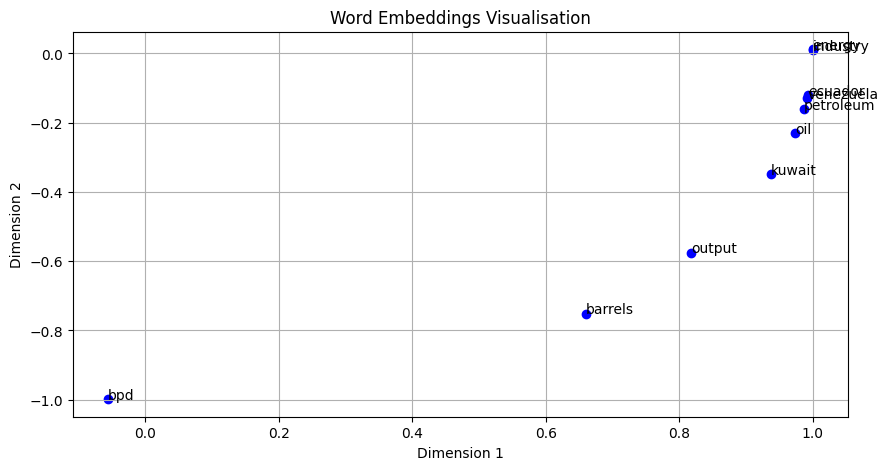

In [49]:
words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)

## Visualization noticies

Как мы видим, в одну группу кластеризовались такие слова как {energy, industry}, {venezuela, petroleum, ecuador} и еще достаточно близко с ними слово 'oil'.

В общем, достаточно логично, чтобы страны были близки друг к другу, а также слова 'oil', 'barrels', 'bpd', 'petroleum'. Но это не так из-за специфики данных, на которых была обучена модель - так скорее всего слова встречались не так, как кажется "логичным".

### Cosine Similarity
Now that we have word vectors, we need a way to quantify the similarity between individual words, according to these vectors. One such metric is cosine-similarity. We will be using this to find words that are "close" and "far" from one another.

We can think of n-dimensional vectors as points in n-dimensional space. If we take this perspective [L1](http://mathworld.wolfram.com/L1-Norm.html) and [L2](http://mathworld.wolfram.com/L2-Norm.html) Distances help quantify the amount of space "we must travel" to get between these two points. Another approach is to examine the angle between two vectors. From trigonometry we know that:

Instead of computing the actual angle, we can leave the similarity in terms of $similarity = cos(\Theta)$. Formally the [Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) $s$ between two vectors $p$ and $q$ is defined as:

$$s = \frac{p \cdot q}{||p|| ||q||}, \textrm{ where } s \in [-1, 1] $$

### Question 2.2: Words with Multiple Meanings (2 points)
Polysemes and homonyms are words that have more than one meaning (see this [wiki page](https://en.wikipedia.org/wiki/Polysemy) to learn more about the difference between polysemes and homonyms ). Find a word with at least 2 different meanings such that the top-10 most similar words (according to cosine similarity) contain related words from *both* meanings. For example, "leaves" has both "vanishes" and "stalks" in the top 10, and "scoop" has both "handed_waffle_cone" and "lowdown". You will probably need to try several polysemous or homonymic words before you find one. Please state the word you discover and the multiple meanings that occur in the top 10. Why do you think many of the polysemous or homonymic words you tried didn't work (i.e. the top-10 most similar words only contain **one** of the meanings of the words)?

**Note**: You should use the `wv_from_bin.most_similar(word)` function to get the top 10 similar words. This function ranks all other words in the vocabulary with respect to their cosine similarity to the given word. For further assistance please check the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [50]:
# ------------------
# Write your implementation here.
# ------------------
pprint.pprint(wv_from_bin.most_similar("lie"))

[('lying', 0.6884376406669617),
 ('lies', 0.6648906469345093),
 ('lay', 0.49874207377433777),
 ('beneath', 0.4979451894760132),
 ('hide', 0.4929002821445465),
 ('exist', 0.49129071831703186),
 ('sit', 0.48945313692092896),
 ('truth', 0.4867425262928009),
 ('bare', 0.48414283990859985),
 ('these', 0.48072928190231323)]


## Why is it hard for model to work with Polysemes and Homonyms?

Как мы видим, для слова 'lie', которое может значить как 'лежать', так и 'врать', в топе самых похожих слов есть слова, относящиеся и к первому значению, и ко второму.

Для некотрых слов этого может не происходить в том случае, если один смысл слова "доминирует" над другим, а также из-за специфики данных, на которых модель обучена.

### Question 2.3: Synonyms & Antonyms (2 points)

When considering Cosine Similarity, it's often more convenient to think of Cosine Distance, which is simply 1 - Cosine Similarity.

Find three words (w1,w2,w3) where w1 and w2 are synonyms and w1 and w3 are antonyms, but Cosine Distance(w1,w3) < Cosine Distance(w1,w2). For example, w1="happy" is closer to w3="sad" than to w2="cheerful".

Once you have found your example, please give a possible explanation for why this counter-intuitive result may have happened.

You should use the the `wv_from_bin.distance(w1, w2)` function here in order to compute the cosine distance between two words. Please see the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.distance)__ for further assistance.

In [51]:
# ------------------
# Write your implementation here.
# ------------------
pprint.pprint(wv_from_bin.distance("clean", "pure"))
pprint.pprint(wv_from_bin.distance("clean", "dirty"))

0.6592543125152588
0.4848299026489258


## Why antonyms may be "closer" to each other than synonyms in terms of cosine similarity?

Это происходит из-за того, что антонимы такие как чистый - грязный в их классической форме встречаются друг другом гораздо чаще, чем 'clean' и 'pure' из-за того, что это необычная форма слова.

### Solving Analogies with Word Vectors
Word vectors have been shown to *sometimes* exhibit the ability to solve analogies.

As an example, for the analogy "man : king :: woman : x" (read: man is to king as woman is to x), what is x?

In the cell below, we show you how to use word vectors to find x. The `most_similar` function finds words that are most similar to the words in the `positive` list and most dissimilar from the words in the `negative` list. The answer to the analogy will be the word ranked most similar (largest numerical value).

**Note:** Further Documentation on the `most_similar` function can be found within the __[GenSim documentation](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.FastTextKeyedVectors.most_similar)__.

In [52]:
# Run this cell to answer the analogy -- man : king :: woman : x
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'king'], negative=['man']))

[('queen', 0.6978678107261658),
 ('princess', 0.6081745028495789),
 ('monarch', 0.5889754891395569),
 ('throne', 0.5775108933448792),
 ('prince', 0.5750998258590698),
 ('elizabeth', 0.5463595986366272),
 ('daughter', 0.5399126410484314),
 ('kingdom', 0.5318052768707275),
 ('mother', 0.5168544054031372),
 ('crown', 0.5164473056793213)]


### Question 2.4: Finding Analogies (2 Points)
Find an example of analogy that holds according to these vectors (i.e. the intended word is ranked top). In your solution please state the full analogy in the form x:y :: a:b. If you believe the analogy is complicated, explain why the analogy holds in one or two sentences.

**Note**: You may have to try many analogies to find one that works!

In [53]:
# ------------------
# Write your implementation here.
# ------------------
# husband : man :: wife : woman
pprint.pprint(wv_from_bin.most_similar(positive=['husband', 'woman'], negative=['man']))

[('wife', 0.824962317943573),
 ('mother', 0.7672861814498901),
 ('daughter', 0.7647711038589478),
 ('married', 0.7143946290016174),
 ('her', 0.6805019974708557),
 ('daughters', 0.6617104411125183),
 ('niece', 0.6577696204185486),
 ('grandmother', 0.6437757015228271),
 ('girlfriend', 0.6396953463554382),
 ('sister', 0.6388186812400818)]


### Guided Analysis of Bias in Word Vectors

It's important to be cognizant of the biases (gender, race, sexual orientation etc.) implicit in our word embeddings. Bias can be dangerous because it can reinforce stereotypes through applications that employ these models.

Run the cell below, to examine (a) which terms are most similar to "woman" and "worker" and most dissimilar to "man", and (b) which terms are most similar to "man" and "worker" and most dissimilar to "woman". Point out the difference between the list of female-associated words and the list of male-associated words, and explain how it is reflecting gender bias.

In [54]:
# Run this cell
# Here `positive` indicates the list of words to be similar to and `negative` indicates the list of words to be
# most dissimilar from.
pprint.pprint(wv_from_bin.most_similar(positive=['woman', 'worker'], negative=['man']))
print()
pprint.pprint(wv_from_bin.most_similar(positive=['man', 'worker'], negative=['woman']))

[('employee', 0.6375863552093506),
 ('workers', 0.6068920493125916),
 ('nurse', 0.5837947130203247),
 ('pregnant', 0.5363885164260864),
 ('mother', 0.5321308970451355),
 ('employer', 0.5127025842666626),
 ('teacher', 0.5099576711654663),
 ('child', 0.5096741318702698),
 ('homemaker', 0.5019454956054688),
 ('nurses', 0.4970572590827942)]

[('workers', 0.611325740814209),
 ('employee', 0.5983108878135681),
 ('working', 0.5615329742431641),
 ('laborer', 0.5442320108413696),
 ('unemployed', 0.536851704120636),
 ('job', 0.5278826355934143),
 ('work', 0.5223963856697083),
 ('mechanic', 0.5088937282562256),
 ('worked', 0.5054520964622498),
 ('factory', 0.4940454363822937)]


## Difficulties with society biases.

Как мы видим, среди слов, близких к 'woman' и 'worker' и далеких от 'man', мы видим больше слов, не относящихся к работе напрямую, а в обоих случаях видим слова, стереотипно относящиеся к мужчинам и женщинам на основании половой принадлежности.

Таким образом, становится понятным, что необходимо регулирование вывода модели.

## Part 3. Sentiment Classification.
In this part, you will perform sentiment analysis using pre-trained model word embeddings. You are free to choose your dataset, and the goal is to build a complete pipeline—from dataset selection to building and evaluating a model.

### 1. Dataset Selection
**Choose a dataset:**

Select any sentiment classification dataset (e.g., product reviews, movie reviews, etc.) that contains labeled text samples. You can use datasets from sources like:

* Kaggle (e.g., IMDB Movie Reviews, Amazon Reviews).
* Hugging Face Dataset Hub.

Split the dataset into training and testing sets (80/20 split).
Display a few sample rows of the dataset to understand the text and labels.

In [55]:
from nltk.corpus import movie_reviews
nltk.download('movie_reviews')

from collections import Counter
from sklearn.model_selection import train_test_split

seed = 42
random.seed(seed)
np.random.seed(seed)

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!


In [56]:
docs = [(movie_reviews.raw(fileid), 1 if category == 'pos' else 0)
             for category in movie_reviews.categories()
             for fileid in movie_reviews.fileids(category)]

print(f"Всего текстов : {len(docs)}\n")

texts = [doc[0] for doc in docs]
labels = [doc[1] for doc in docs]

texts = np.array(texts)
labels = np.array(labels)

label_distribution = Counter(labels)

print("Распределение меток:")
for label, count in label_distribution.items():
    print(f"{label}: {count}")

Всего текстов : 2000

Распределение меток:
0: 1000
1: 1000


In [57]:
X_train, X_test, y_tr, y_tst = train_test_split(texts, labels, test_size=0.2, random_state=seed)

print("-"*25)
print("Обучающий набор примеров:")
print("-"*25)
for i in random.sample(range(len(X_train)), 3):
    print(f"Текст: {X_train[i][:100]}...")
    print(f"Метка: {'positive' if y_tr[i] else 'negative'}")
    print()

print("-"*24)
print("Тестовый набор примеров:")
print("-"*24)
for i in random.sample(range(len(X_test)), 3):
    print(f"Текст: {X_test[i][:100]}...")
    print(f"Метка: {'positive' if y_tst[i] else 'negative'}")
    print()

-------------------------
Обучающий набор примеров:
-------------------------
Текст: the main problem with martin lawrence's pet project , a thin line between love and hate , like any f...
Метка: negative

Текст: to sum the entire film " 54 " up in one sentence , it would be : watch a vh1 documentary instead . 
...
Метка: negative

Текст:  " if there's a beast in men , it meets its match in women , too . " 
starring sarah patterson , ang...
Метка: positive

------------------------
Тестовый набор примеров:
------------------------
Текст: an astonishingly difficult movie to watch , the last temptation of = christ may be scorsese's most i...
Метка: positive

Текст: matthew broderick and high school comedy . 
the two terms have been practically inseparable since fe...
Метка: positive

Текст: imagine this scenario : you and any of your family members are scudding through one of those long , ...
Метка: positive



### 2. Data Preprocessing.
Preprocess the text data by performing the following tasks.
* Convert text to lowercase.
* Remove punctuation, non-alphabetic characters, and stopwords.
* Tokenize the text into words.




In [58]:
from sklearn.feature_extraction import _stop_words
import string

In [59]:
stopwords = _stop_words.ENGLISH_STOP_WORDS

def clean_tokenize(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation and not char.isdigit()])
    text = " ".join([token for token in text.split() if token not in stopwords])

    return text.split()

In [60]:
X_tr = [clean_tokenize(text) for text in X_train]
X_tst = [clean_tokenize(text) for text in X_test]

### 3. Word Embedding Representation:
You can use pre-trained GloVe embeddings from the task above. Create an embedding matrix where each word in your dataset is mapped to its pre-trained GloVe vector.


In [61]:
def convert_texts_to_glove_vectors(docs, wv_from_bin):
    """
    Преобразует каждый текст в список векторов слов.

    Params:
      docs (list of lists): список списков, где каждый список — это токенизированный текст
      wv_from_bin: загруженная модель GloVe

    Returns:
      list: каждый список содержит векторизированные тексты (если это слово есть в GloVe)
    """
    docs_word_vectors = []

    for doc in docs:
        word_vectors = [wv_from_bin.get_vector(word) for word in doc if word in wv_from_bin]
        doc_word_vectors = np.mean(word_vectors, axis=0)
        docs_word_vectors.append(doc_word_vectors)

    return np.array(docs_word_vectors)

In [62]:
X_tr_vect = convert_texts_to_glove_vectors(X_tr, wv_from_bin)
X_tst_vect = convert_texts_to_glove_vectors(X_tst, wv_from_bin)

### 4. Model Building.
Design the model architecture for sentiment classification, using algorithms we covered in lectures.

***Important!***

Pease, don't use RNNs and transformer architectures, as we will cover these topics in upcoming lectures.


In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import tqdm.notebook as tqdm

In [80]:
class MyDataset(Dataset):
    def __init__(self, xs, ys):
        super().__init__()

        if len(xs) != len(ys):
            raise ValueError(f"lens mismatch: {len(xs)} != {len(ys)}")

        self.xs = xs
        self.ys = ys

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, i):
        return (self.xs[i], self.ys[i])

    @staticmethod
    def collate_fn(items_list):
        xs = torch.zeros(len(items_list), 1, len(items_list[0][0]), dtype=torch.float)
        ys = torch.zeros(len(items_list), dtype=torch.long)

        for i, (x, y) in enumerate(items_list):
            xs[i] = x.unsqueeze(0)
            ys[i] = y

        return xs, ys

In [81]:
class MyModel(nn.Module):
    def __init__(self, input_dim, num_classes):
        """
        Инициализация модели с использованием nn.Sequential.

        Params:
            input_dim (int): размер входных данных (число признаков).
            num_classes (int): количество классов для классификации.
        """
        super(MyModel, self).__init__()

        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),

            nn.Flatten(),

            nn.Linear(64 * (input_dim // 8), 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

In [110]:
def training_loop(n_epochs, network, loss_fn, optimizer, dl_train, dl_test):
    '''
    :param int n_epochs: Число итераций оптимизации
    :param torch.nn.Module network: Нейронная сеть
    :param Callable loss_fn: Функция потерь
    :param torch.nn.Optimizer optimizer: Оптимизатор
    :param torch.utils.data.DataLoader dl_train: Даталоадер для обучающей выборки
    :param torch.utils.data.DataLoader dl_test: Даталоадер для тестовой выборки
    :param torch.Device device: Устройство на котором будут происходить вычисления
    :returns: Списки значений функции потерь и точности на обучающей и тестовой выборках после каждой итерации
    '''
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
    epoch_list = []

    for epoch in (pbar := tqdm.tqdm(range(n_epochs), total=n_epochs, leave=False)):
        # Переводим сеть в режим обучения
        network.train()

        # Итерация обучения сети
        for images, labels in tqdm.tqdm(dl_train, total=len(dl_train), leave=False):
            # Шаг оптимизации
            images, labels = images, labels
            optimizer.zero_grad()
            output = network(images)
            loss = loss_fn(output, labels)
            loss.backward()
            optimizer.step()

        if epoch % 3 == 0 or epoch == n_epochs - 1:
            epoch_list.append(epoch)
            # Переводим сеть в инференс режим
            network.eval()

            with torch.no_grad():
                # Вычисление качества и функции потерь на обучающей выборке
                batch_loss = []
                correct_out = 0
                num_samples = 0
                for images, labels in dl_train:
                    images, labels = images, labels
                    output = network(images)

                    _, idx_max = torch.max(output, dim=1)
                    correct_out += (idx_max == labels).sum().item()
                    num_samples += len(labels)

                    loss = loss_fn(output, labels)
                    batch_loss.append(loss)

                train_losses.append(torch.tensor(batch_loss).mean().item())
                train_accuracies.append(correct_out * 100 / num_samples)

                # Вычисление качества и функции потерь на тестовой выборке
                batch_loss = []
                correct_out = 0
                num_samples = 0
                for images, labels in dl_test:
                    images, labels = images, labels
                    output = network(images)

                    _, idx_max = torch.max(output, dim=1)
                    correct_out += (idx_max == labels).sum().item()
                    num_samples += len(labels)

                    loss = loss_fn(output, labels)
                    batch_loss.append(loss)

                test_losses.append(torch.tensor(batch_loss).mean().item())
                test_accuracies.append(correct_out * 100 / num_samples)

            pbar.set_description(
                'Loss (Train/Test): {0:.3f}/{1:.3f}. Accuracy, % (Train/Test): {2:.2f}/{3:.2f}\n'.format(
                    train_losses[-1], test_losses[-1], train_accuracies[-1], test_accuracies[-1]
                )
            )

    return train_losses, test_losses, train_accuracies, test_accuracies, epoch_list

In [111]:
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, epoch_list):
    """
    Построение графиков потерь и точности по эпохам.

    Params:
        train_losses (list): список значений потерь на train по эпохам.
        test_losses (list): список значений потерь на test по эпохам.
        train_accuracies (list): список значений точности на train по эпохам.
        test_accuracies (list): список значений точности на test по эпохам.
    """
    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(epoch_list, train_losses, label='Train', color='blue')
    plt.plot(epoch_list, test_losses, label='Test', color='red')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(epoch_list, train_accuracies, label='Train', color='blue')
    plt.plot(epoch_list, test_accuracies, label='Test', color='red')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

### 5. Model Training and Evaluation:
Train the model on the training data and validate the performance on the validation set. Evaluate the model on the test data using appropriate metrics, such as: Accuracy, Precision, Recall, and F1-score. Plot training and validation loss and accuracy curves to understand model performance.


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Веса модели сохранены!


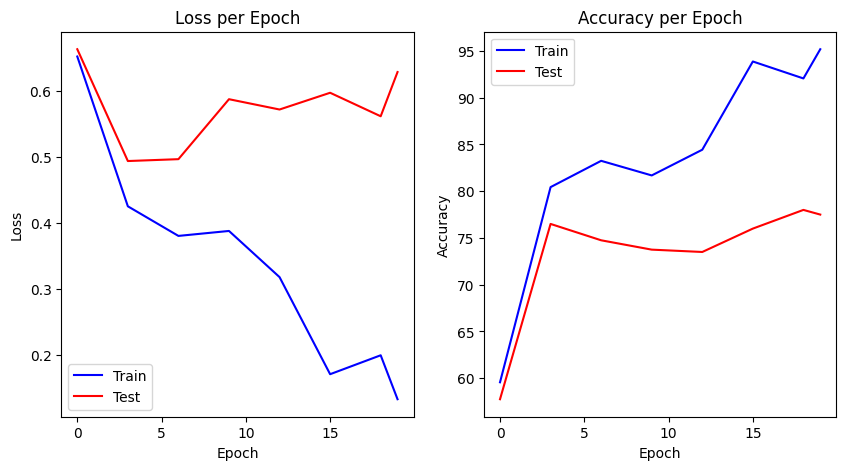

In [112]:
X_train_tensor = torch.tensor(X_tr_vect)
y_train_tensor = torch.tensor(y_tr)
X_test_tensor = torch.tensor(X_tst_vect)
y_test_tensor = torch.tensor(y_tst)

train_dataset = MyDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, drop_last=True, collate_fn=MyDataset.collate_fn)

test_dataset = MyDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False, drop_last=False, collate_fn=MyDataset.collate_fn)

input_dim = X_tr_vect.shape[1]
num_classes = len(set(y_tr))

model = MyModel(input_dim, num_classes)

num_epochs = 20
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses, test_losses, train_accuracies, test_accuracies, epoch_list = training_loop(num_epochs, model, loss_fn, optimizer, train_loader, test_loader)

torch.save(model.state_dict(), 'my_model_weights.pth')
print("Веса модели сохранены!")

plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies, epoch_list)

# Пожалуйста, объясните, почему лосс на тесте почти не падает, а даже растет ((( Модель переобучается? @alexxponomarenko